Submitted by:  
SAJIN MOHAMED PALLIKKATHODI ERATHALI (23037601)  
AKHIL RAGHU NATH (23048417)

THE CODE EXECUTES WITHOUT AN ERROR TO COMPLETION

Modified the code from the below sources:  
1. https://www.kaggle.com/code/songrise/implementing-resnet-18-using-keras referencing on [1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
2. https://www.kaggle.com/code/stefanie04736/simple-keras-model-with-k-fold-cross-validation
3. https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md
4. https://www.kaggle.com/code/arunkanthali/cifar10-resnet-18-using-keras/notebook?scriptVersionId=142599768

## Imports

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tabulate import tabulate
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Add, Dropout
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Loading Cifar 10 Dataset [Section 1]

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 [==============================] - 4s 0us/step


## Visualization of some samples from dataset [Section 1]

Minimum Image Size - Height: 32 Width: 32
Maximum Image Size - Height: 32 Width: 32


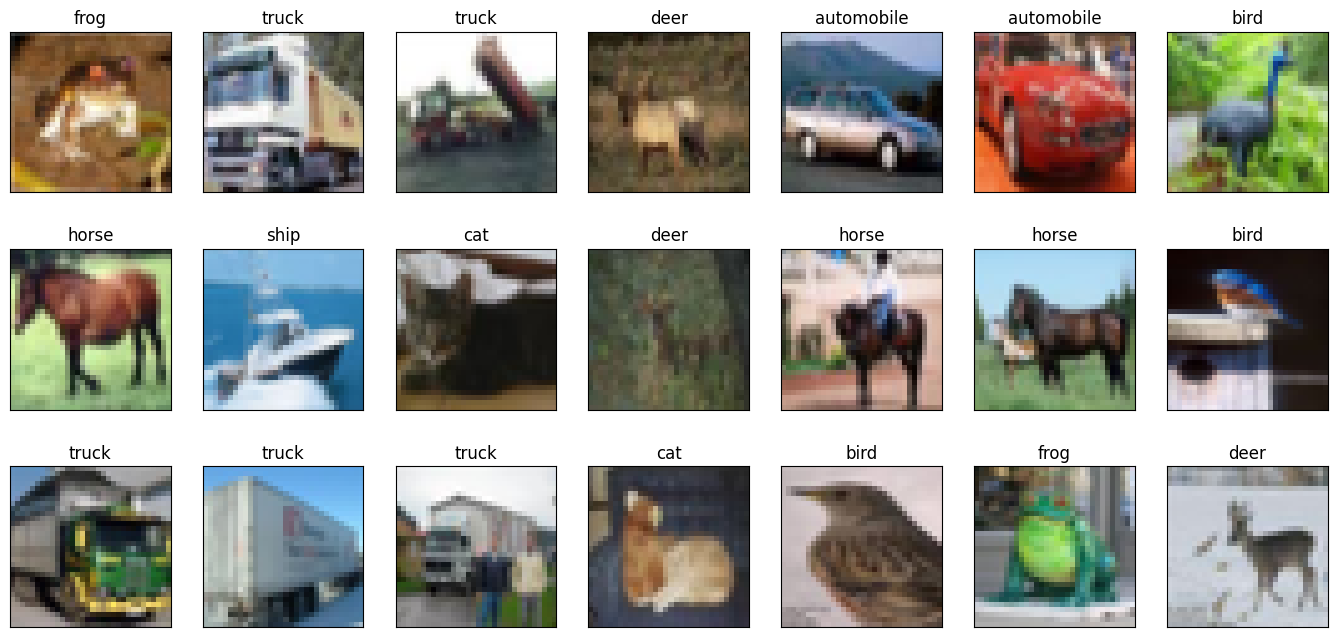

In [ ]:
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(17, 8))
index = 0
min_height = float('inf')
max_height = 0
min_width = float('inf')
max_width = 0
for i in range(3):
    for j in range(7):
        axes[i,j].set_title(CLASS_NAMES[y_train[index][0]])
        axes[i,j].imshow(X_train[index], cmap='gray')
        height, width, _ = X_train[index].shape
        min_height = min(min_height, height)
        max_height = max(max_height, height)
        min_width = min(min_width, width)
        max_width = max(max_width, width)
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1


print("Minimum Image Size - Height:", min_height, "Width:", min_width)
print("Maximum Image Size - Height:", max_height, "Width:", max_width)
plt.show()

## Normalization of Dataset [Section 2.1]

In [ ]:
X_train = X_train.astype('float32')
X_train  = X_train/255.0
X_test = X_test.astype('float32')
X_test  = X_test/255.0

## One-hot Encoding [Section 2.3]

In [ ]:
# One-hot encode the target labels
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(y_train)
y_train = one_hot_encoder.transform(y_train)
y_test = one_hot_encoder.transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Data-Augmentation [Section 2.2]

In [ ]:


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# Example usage during training
datagen.fit(X_train)

## SE Block [Section 3.2]

In [17]:
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, filters, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc1 = tf.keras.layers.Dense(filters // reduction_ratio, activation='relu')
        self.fc2 = tf.keras.layers.Dense(filters, activation='sigmoid')

    def call(self, inputs):
        x = self.avg_pool(inputs)
        x = self.fc1(x)
        x = self.fc2(x)
        x = tf.expand_dims(tf.expand_dims(x, 1), 1)
        return inputs * x

## Resnet 18 Block [Section 3.1]

In [ ]:
"""
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
https://www.kaggle.com/code/songrise/implementing-resnet-18-using-keras
"""
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels is same as number of kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        # down sampling to match the input with the output dimensions for skip connection to be joined to the output
        if down_sample:
          self.__strides = [2, 1]
        else:
          self.__strides = [1, 1]

        # KERNEL_SIZE = (3, 3)
        # same padding

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=(3, 3), padding="same", use_bias=False)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=(3, 3), padding="same", use_bias=False)
        self.se_block = SEBlock(channels)
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, when down sampling required for changing channel sizes with skip connection
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), padding="same", use_bias=False)
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        # Main path of the ResNet block
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)

        # If downsampling is to be performed, the input is also downsampled before being added to the output of the main path
        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)
        # SE block added
        x = self.se_block(x)
        # Skip connection: the original input/identity (possibly downsampled) is added to the output of the main path
        x = self.merge([x, res])

        out = tf.nn.relu(x)
        return out


def ResNet18(num_classes):

        """
            num_classes: number of classes in specific classification task.
            Here we have 10
        """
        # defining a sequential model so that we can define the summary and for readability
        model = Sequential()
        model.add(Conv2D(64, (7, 7), strides=2,
                              padding="same", use_bias=False))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
        model.add(ResnetBlock(64))
        model.add(ResnetBlock(64))
        model.add(ResnetBlock(128, down_sample=True))
        model.add(ResnetBlock(128))
        model.add(ResnetBlock(256, down_sample=True))
        model.add(ResnetBlock(256))
        model.add(ResnetBlock(512, down_sample=True))
        model.add(ResnetBlock(512))
        model.add(GlobalAveragePooling2D())
        model.add(Dense(num_classes, activation='softmax'))

        return model


## Learning rate Scheduler [Section 4.1]

## Learning Rate adjusted on epoch numbers used along with ReduceLROnPlateau [section 4.2]

In [19]:

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 15, 20, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 20:
        lr *= 1e-3
    elif epoch > 15:
        lr *= 1e-2
    print('Learning rate: ', lr)
    return lr

## Defining Kfold containers and fold details [Section 7]

In [10]:
acc_per_fold = []
loss_per_fold = []
history_list = []

num_folds = 5
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation

Constructing and running the model within a loop of K-fold cross-validation.

In [ ]:

fold_no = 1
for train, test in kfold.split(X_train, y_train):

    # Define model
    num_classes = 10
    model = ResNet18(num_classes)

    # Compile the model
    model.compile(optimizer='Nadam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Training parameters
    batch_size = 150
    epochs = 25

    # Callbacks
    lr_scheduler = LearningRateScheduler(lr_schedule)
    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                    cooldown=0,
                                    patience=5,
                                    min_lr=0.5e-6)
    callbacks = [lr_reducer, lr_scheduler]

    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train[train], X_train[test]
    y_train_fold, y_val_fold = y_train[train], y_train[test]

    # Train the model
    history = model.fit(datagen.flow(X_train_fold, y_train_fold, batch_size=batch_size),
                        epochs=epochs,
                        shuffle=True,
                        verbose=1,
                        validation_data=(X_val_fold, y_val_fold),
                        callbacks=callbacks)

    # Append history to list for plotting later
    history_list.append(history)
    # Generate generalization metrics
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1



------------------------------------------------------------------------
Training for fold 1 ...


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Learning rate:  0.001
Epoch 1/25
267/267 [==============================] - 67s 136ms/step - loss: 1.5078 - accuracy: 0.4565 - val_loss: 3.0405 - val_accuracy: 0.1689 - lr: 0.0010
Learning rate:  0.001
Epoch 2/25
267/267 [==============================] - 34s 126ms/step - loss: 1.2046 - accuracy: 0.5692 - val_loss: 1.3480 - val_accuracy: 0.5299 - lr: 0.0010
Learning rate:  0.001
Epoch 3/25
267/267 [==============================] - 30s 114ms/step - loss: 1.0698 - accuracy: 0.6208 - val_loss: 1.3886 - val_accuracy: 0.5306 - lr: 0.0010
Learning rate:  0.001
Epoch 4/25
267/267 [==============================] - 49s 186ms/step - loss: 0.9753 - accuracy: 0.6534 - val_loss: 1.1081 - val_accuracy: 0.6178 - lr: 0.0010
Learning rate:  0.001
Epoch 5/25
267/267 [==============================] - 36s 135ms/step - loss: 0.8978 - accuracy: 0.6804 - val_loss: 1.1921

## Result [Section 8]

Printing Average score per fold

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')



------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5512568354606628 - Accuracy: 81.27999901771545%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.5562928915023804 - Accuracy: 81.48000240325928%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.5466974377632141 - Accuracy: 81.36000037193298%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.5625331401824951 - Accuracy: 80.94000220298767%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.54581618309021 - Accuracy: 81.11000061035156%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 81.23400092124939 (+- 0.18990510211388273)
> Loss: 0.5525192975997925
-----------------------------

## Plotting the graphs(Average accuracy vs folds and Average loss vs number of folds) [Section 9]

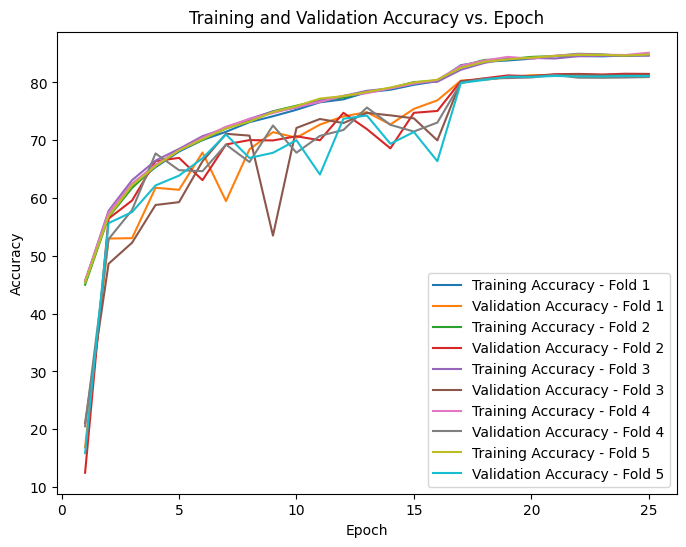

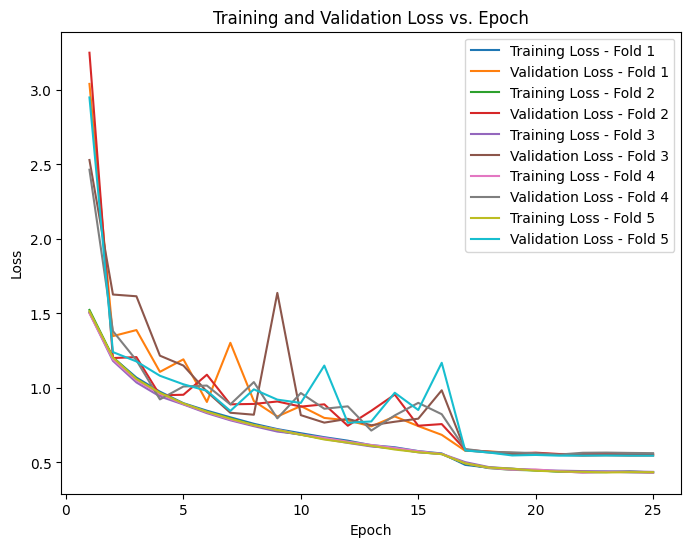

In [ ]:
# Plotting training and validation accuracy for all folds
plt.figure(figsize=(8, 6))
for i, history in enumerate(history_list):
    # Multiply accuracy values by 100 to scale them to the range of 0 to 100
    training_accuracy = [acc * 100 for acc in history.history['accuracy']]
    validation_accuracy = [acc * 100 for acc in history.history['val_accuracy']]

    plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label=f'Training Accuracy - Fold {i+1}')
    plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label=f'Validation Accuracy - Fold {i+1}')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.show()

# Plotting training and validation loss for all folds
plt.figure(figsize=(8, 6))
for i, history in enumerate(history_list):
    plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label=f'Training Loss - Fold {i+1}')
    plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label=f'Validation Loss - Fold {i+1}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epoch')
plt.legend()
plt.show()


Prediction on Test data

In [ ]:
# Predicting test data
predictions = model.predict(X_test)
# Convert predictions to multiclass labels
predictions = np.argmax(predictions, axis=1)

# Convert y_test from one-hot encoded format to single-label format
y_test_single_label = np.argmax(y_test, axis=1)



313/313 [==============================] - 2s 5ms/step


Printing Classification report

In [ ]:
print(classification_report(y_test_single_label, predictions))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1000
           1       0.87      0.90      0.88      1000
           2       0.82      0.69      0.75      1000
           3       0.71      0.55      0.62      1000
           4       0.78      0.79      0.79      1000
           5       0.75      0.69      0.72      1000
           6       0.77      0.92      0.84      1000
           7       0.82      0.87      0.85      1000
           8       0.91      0.89      0.90      1000
           9       0.79      0.89      0.84      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



## Printing Confusion Matrix

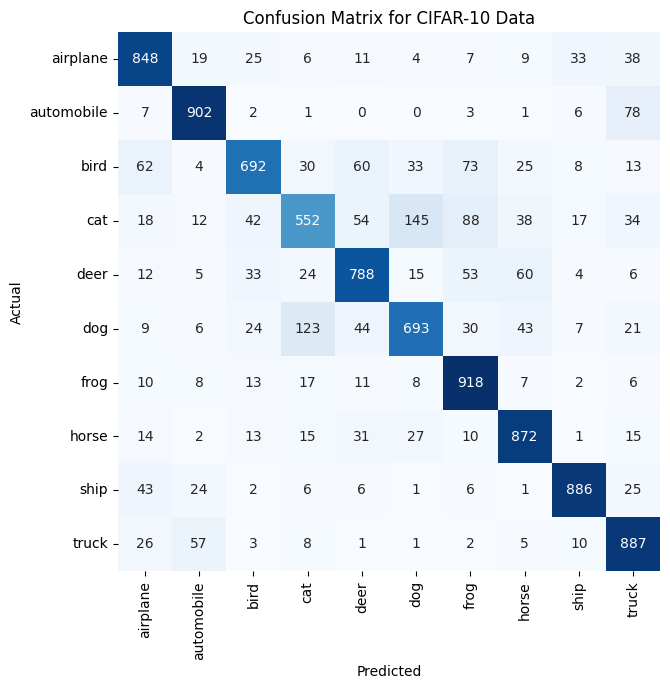

In [ ]:
# Define labels for visualization
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Creating confusion matrix
cm = confusion_matrix(y_test_single_label, predictions)

# Plotting confusion matrix
plt.figure(figsize=(7, 7))
sns.heatmap(cm, cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CIFAR-10 Data')
plt.show()

In [ ]:
# Calculate precision, recall, and accuracy for each class
precision_per_class = precision_score(y_true=y_test_single_label, y_pred=predictions, average=None)
recall_per_class = recall_score(y_true=y_test_single_label, y_pred=predictions, average=None)
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
# Store class metrics in a list of lists
class_metrics_table = []
for i, label in enumerate(labels):
    class_metrics_table.append([label, precision_per_class[i], recall_per_class[i], accuracy_per_class[i]])

# Print table using tabulate
print(tabulate(class_metrics_table, headers=['Class', 'Precision', 'Recall', 'Accuracy'], tablefmt='grid'))

+------------+-------------+----------+------------+
| Class      |   Precision |   Recall |   Accuracy |
+============+=============+==========+============+
| airplane   |    0.808389 |    0.848 |      0.848 |
+------------+-------------+----------+------------+
| automobile |    0.868142 |    0.902 |      0.902 |
+------------+-------------+----------+------------+
| bird       |    0.815077 |    0.692 |      0.692 |
+------------+-------------+----------+------------+
| cat        |    0.705882 |    0.552 |      0.552 |
+------------+-------------+----------+------------+
| deer       |    0.7833   |    0.788 |      0.788 |
+------------+-------------+----------+------------+
| dog        |    0.747573 |    0.693 |      0.693 |
+------------+-------------+----------+------------+
| frog       |    0.771429 |    0.918 |      0.918 |
+------------+-------------+----------+------------+
| horse      |    0.821866 |    0.872 |      0.872 |
+------------+-------------+----------+-------

## Visualizing Test Data Predicted and Actual of some sample data

(10000, 32, 32, 3)


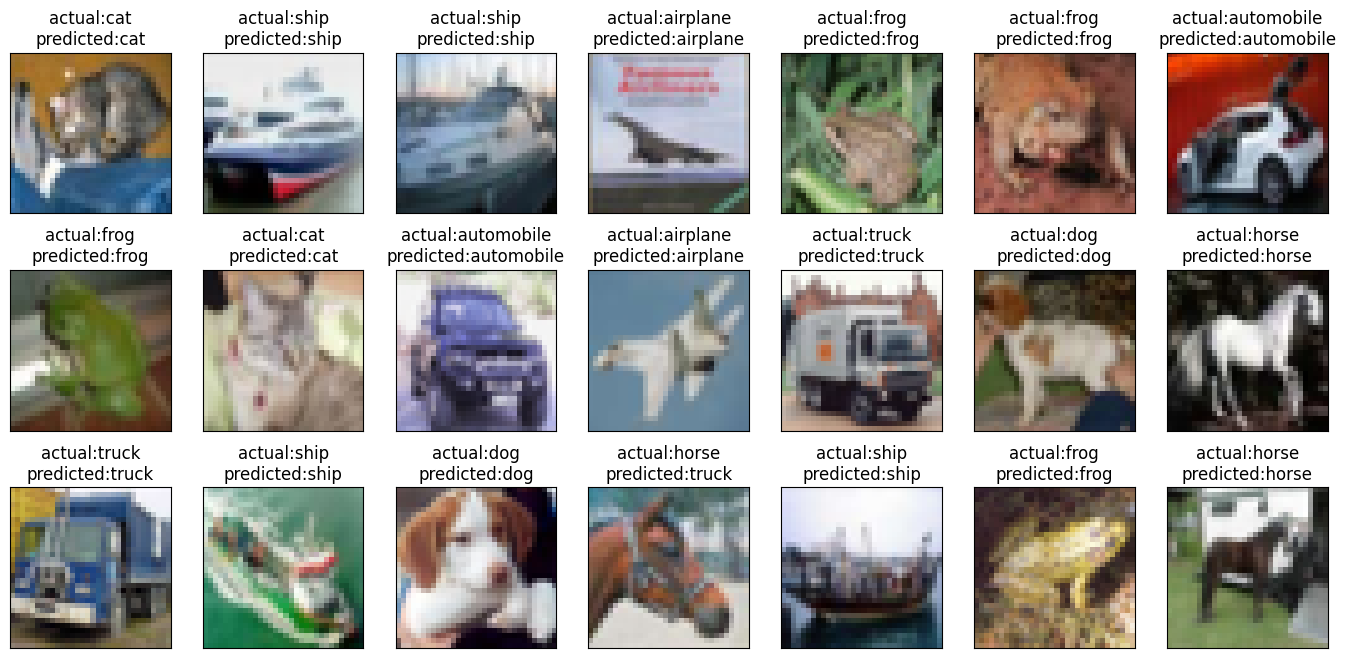

In [ ]:


# Displaying test data with its actual and predicted label
print(X_test.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3])

# Plot actual vs. predicted labels
fig, axes = plt.subplots(ncols=7, nrows=3, sharex=False, sharey=True, figsize=(17, 8))
for i in range(3):
    for j in range(7):
        idx = i * 7 + j  # Calculate the correct index
        actual_label = labels[int(y_test_single_label[idx])]
        predicted_label = labels[int(predictions[idx])]
        axes[i,j].set_title('actual:' + actual_label + '\n' + 'predicted:' + predicted_label)
        axes[i,j].imshow(X_test[idx], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)

## The Reliability Diagram  
## [Section 9]

313/313 [==============================] - 2s 5ms/step


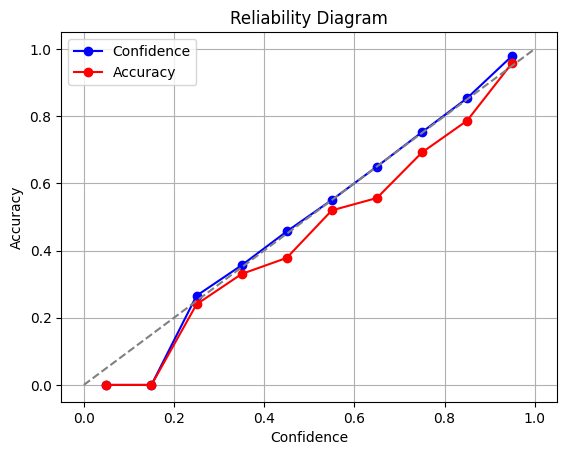

In [ ]:
def reliability_diagram(y_true, y_prob, num_bins=10):
    """
    Compute and plot the reliability diagram.

    Parameters:
    y_true (numpy array): True labels (ground truth) for the samples.
    y_prob (numpy array): Predicted probabilities for each class.
    num_bins (int): Number of bins for the reliability diagram. Default is 10.
    """
    assert y_true.shape == y_prob.shape, "Shapes of y_true and y_prob must be the same."

    # Check if the number of bins is valid
    num_classes = y_true.shape[1]
    if num_bins > num_classes:
        raise ValueError("Number of bins cannot exceed the number of classes.")

    # Get the predicted class labels and the maximum predicted probability
    y_pred = np.argmax(y_prob, axis=1)
    max_probs = np.max(y_prob, axis=1)

    # Create bins for predicted probabilities
    bin_edges = np.linspace(0, 1, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Initialize arrays to store the accuracy and confidence for each bin
    acc_bins = np.zeros(num_bins)
    conf_bins = np.zeros(num_bins)
    bin_counts = np.zeros(num_bins)

    # Compute accuracy and confidence for each bin
    for bin_idx in range(num_bins):
      # boolean mask indicating which samples fall within the current bin
        mask = (max_probs >= bin_edges[bin_idx]) & (max_probs < bin_edges[bin_idx + 1])
        if np.any(mask):
            # number of samples in each bin is stored
            bin_counts[bin_idx] = np.sum(mask)
            bin_samples = y_true[mask]
            bin_preds = y_pred[mask]
            bin_probs = y_prob[mask]

            # Calculates the accuracy within the bin by comparing the ground truth labels with the predicted labels
            bin_accuracy = np.mean(bin_samples[np.arange(len(bin_samples)), bin_preds])
            # Computes the confidence within the bin by averaging the maximum predicted probabilities for each sample
            bin_confidence = np.mean(np.max(bin_probs, axis=1))
            acc_bins[bin_idx] = bin_accuracy
            conf_bins[bin_idx] = bin_confidence

    # Plot the reliability diagram
    plt.plot(bin_centers, conf_bins, marker='o', label='Confidence', color='blue')
    plt.plot(bin_centers, acc_bins, marker='o', label='Accuracy', color='red')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfect calibration line
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.grid(True)
    plt.savefig('Reliability Diagram.png')
    plt.show()

    return acc_bins, conf_bins, bin_counts


y_test_predict = model.predict(X_test)
acc_bins, conf_bins, bin_counts = reliability_diagram(y_test, y_test_predict)


# Overfitting Engineered [Section 10.1]

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 [==============================] - 4s 0us/step


In [4]:
X_train = X_train.astype('float32')
X_train  = X_train/255.0
X_test = X_test.astype('float32')
X_test  = X_test/255.0

In [5]:
# One-hot encode the target labels
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(y_train)
y_train = one_hot_encoder.transform(y_train)
y_test = one_hot_encoder.transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
"""
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
https://www.kaggle.com/code/songrise/implementing-resnet-18-using-keras
"""
class ResNet18(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels is same as number of kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        # down sampling to match the input with the output dimensions for skip connection to be joined to the output
        if down_sample:
          self.__strides = [2, 1]
        else:
          self.__strides = [1, 1]

        # KERNEL_SIZE = (3, 3)
        # same padding

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=(3, 3), padding="same", use_bias=False)
        # self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=(3, 3), padding="same", use_bias=False)
        self.se_block = SEBlock(channels)
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, when down sampling required for changing channel sizes with skip connection
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), padding="same", use_bias=False)
            # self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        # Main path of the ResNet block
        x = self.conv_1(inputs)
        #x = self.bn_1(x) # Batch Normalization Removed
        x = tf.nn.relu(x)
        x = self.conv_2(x)

        # If downsampling is to be performed, the input is also downsampled before being added to the output of the main path
        if self.__down_sample:
            res = self.res_conv(res)
            #res = self.res_bn(res) # Batch Normalization Removed
        # SE block added
        x = self.se_block(x)
        # Skip connection: the original input/identity (possibly downsampled) is added to the output of the main path
        x = self.merge([x, res])

        out = tf.nn.relu(x)
        return out


def ResNet18_Without_BN(num_classes):

        """
            num_classes: number of classes in specific classification task.
            Here we have 10
        """
        # defining a sequential model so that we can define the summary and for readability
        model = Sequential()
        model.add(Conv2D(64, (7, 7), strides=2,
                              padding="same", use_bias=False))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
        model.add(ResNet18(64))
        model.add(ResNet18(64))
        model.add(ResNet18(128, down_sample=True))
        model.add(ResNet18(128))
        model.add(ResNet18(256, down_sample=True))
        model.add(ResNet18(256))
        model.add(ResNet18(512, down_sample=True))
        model.add(ResNet18(512))
        model.add(GlobalAveragePooling2D())
        model.add(Dense(num_classes, activation='softmax'))

        return model


In [20]:




"""
REference:
https://www.kaggle.com/code/stefanie04736/simple-keras-model-with-k-fold-cross-validation
https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul


"""
fold_no = 1
for train, test in kfold.split(X_train, y_train):

    # Define model
    num_classes = 10
    model = ResNet18_Without_BN(num_classes)

    # Compile the model
    model.compile(optimizer='Nadam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Training parameters
    batch_size = 150
    epochs = 25

    # Callbacks
    lr_scheduler = LearningRateScheduler(lr_schedule)
    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                    cooldown=0,
                                    patience=5,
                                    min_lr=0.5e-6)
    callbacks = [lr_reducer, lr_scheduler]

    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train[train], X_train[test]
    y_train_fold, y_val_fold = y_train[train], y_train[test]

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, batch_size=batch_size,  # Image Data Generator.flow removed
                        epochs=epochs,
                        shuffle=True,
                        verbose=1,
                        validation_data=(X_val_fold, y_val_fold),
                        callbacks=callbacks)

    # Append history to list for plotting later
    history_list.append(history)
    # Generate generalization metrics
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1



------------------------------------------------------------------------
Training for fold 1 ...
Learning rate:  0.001
Epoch 1/25


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
267/267 [==============================] - 35s 51ms/step - loss: 1.4689 - accuracy: 0.4635 - val_loss: 1.6712 - val_accuracy: 0.4136 - lr: 0.0010
Learning rate:  0.001
Epoch 2/25
267/267 [==============================] - 13s 47ms/step - loss: 1.0455 - accuracy: 0.6256 - val_loss: 1.2935 - val_accuracy: 0.5484 - lr: 0.0010
Learning rate:  0.001
Epoch 3/25
267/267 [==============================] - 11s 41ms/step - loss: 0.8225 - accuracy: 0.7101 - val_loss: 1.0250 - val_accuracy: 0.6391 - lr: 0.0010
Learning rate:  0.001
Epoch 4/25
267/267 [==============================] - 11s 41ms/step - loss: 0.6525 - accuracy: 0.7697 - val_loss: 1.0778 - val_accuracy: 0.6354 - lr: 0.0010
Learning rate:  0.001
Epoch 5/25
267/267 [==============================] - 11s 41ms/step - loss: 0.5046 - accuracy: 0.8216 - val_loss: 1.0682 - val_accuracy: 0.6650 - lr: 0.0010
L

In [21]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')



------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.57719087600708 - Accuracy: 71.32999897003174%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.6772253513336182 - Accuracy: 70.85999846458435%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.6110676527023315 - Accuracy: 71.20000123977661%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.5719860792160034 - Accuracy: 71.60000205039978%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.6191816329956055 - Accuracy: 71.4900016784668%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 71.29600048065186 (+- 0.25710812072219746)
> Loss: 1.6113303184509278
------------------------------

## Plotting the graphs(Average accuracy vs folds and Average loss vs number of folds) Overfitting

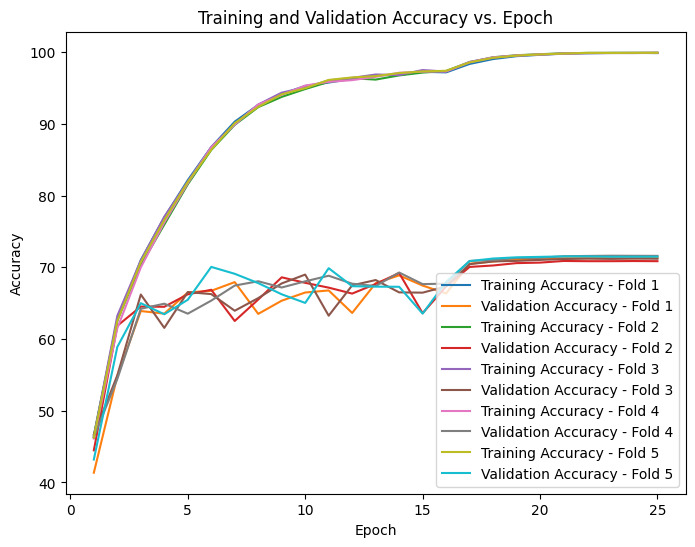

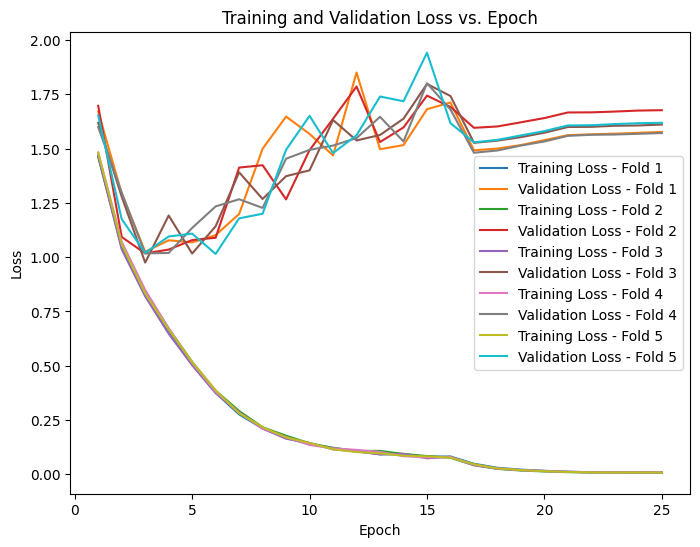

In [22]:
# Plotting training and validation accuracy for all folds
plt.figure(figsize=(8, 6))
for i, history in enumerate(history_list):
    # Multiply accuracy values by 100 to scale them to the range of 0 to 100
    training_accuracy = [acc * 100 for acc in history.history['accuracy']]
    validation_accuracy = [acc * 100 for acc in history.history['val_accuracy']]

    plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label=f'Training Accuracy - Fold {i+1}')
    plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label=f'Validation Accuracy - Fold {i+1}')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.show()

# Plotting training and validation loss for all folds
plt.figure(figsize=(8, 6))
for i, history in enumerate(history_list):
    plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label=f'Training Loss - Fold {i+1}')
    plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label=f'Validation Loss - Fold {i+1}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epoch')
plt.legend()
plt.show()


In [23]:
# Predicting test data
predictions = model.predict(X_test)
# Convert predictions to multiclass labels
predictions = np.argmax(predictions, axis=1)

# Convert y_test from one-hot encoded format to single-label format
y_test_single_label = np.argmax(y_test, axis=1)



313/313 [==============================] - 2s 5ms/step


## Printing Confusion Matrix(Overfitting))

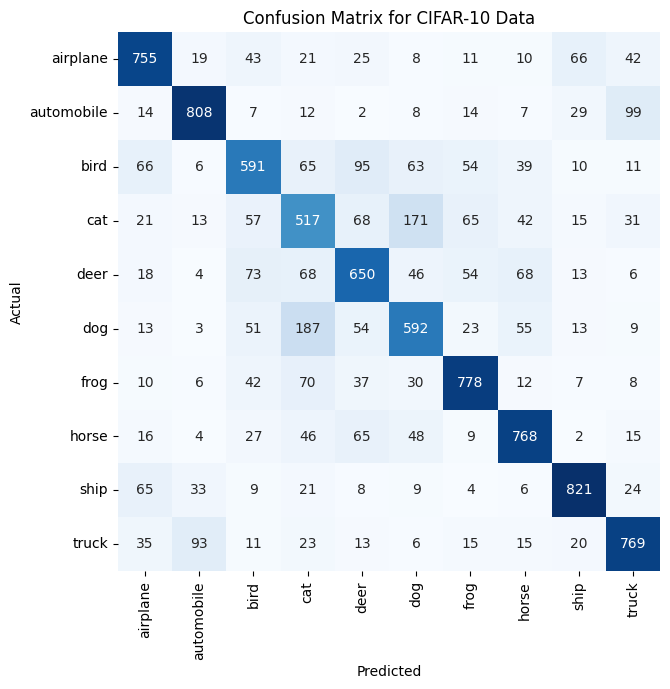

In [24]:
# Define labels for visualization
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Creating confusion matrix
cm = confusion_matrix(y_test_single_label, predictions)

# Plotting confusion matrix
plt.figure(figsize=(7, 7))
sns.heatmap(cm, cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CIFAR-10 Data')
plt.show()

In [25]:
# Calculate precision, recall, and accuracy for each class
precision_per_class = precision_score(y_true=y_test_single_label, y_pred=predictions, average=None)
recall_per_class = recall_score(y_true=y_test_single_label, y_pred=predictions, average=None)
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
# Store class metrics in a list of lists
class_metrics_table = []
for i, label in enumerate(labels):
    class_metrics_table.append([label, precision_per_class[i], recall_per_class[i], accuracy_per_class[i]])

# Print table using tabulate
print(tabulate(class_metrics_table, headers=['Class', 'Precision', 'Recall', 'Accuracy'], tablefmt='grid'))

+------------+-------------+----------+------------+
| Class      |   Precision |   Recall |   Accuracy |
+============+=============+==========+============+
| airplane   |    0.745311 |    0.755 |      0.755 |
+------------+-------------+----------+------------+
| automobile |    0.816987 |    0.808 |      0.808 |
+------------+-------------+----------+------------+
| bird       |    0.648738 |    0.591 |      0.591 |
+------------+-------------+----------+------------+
| cat        |    0.501942 |    0.517 |      0.517 |
+------------+-------------+----------+------------+
| deer       |    0.639135 |    0.65  |      0.65  |
+------------+-------------+----------+------------+
| dog        |    0.603466 |    0.592 |      0.592 |
+------------+-------------+----------+------------+
| frog       |    0.757546 |    0.778 |      0.778 |
+------------+-------------+----------+------------+
| horse      |    0.751468 |    0.768 |      0.768 |
+------------+-------------+----------+-------

## Visualizing Test Data Predicted and Actual of some sample data (OverFitting)

(10000, 32, 32, 3)


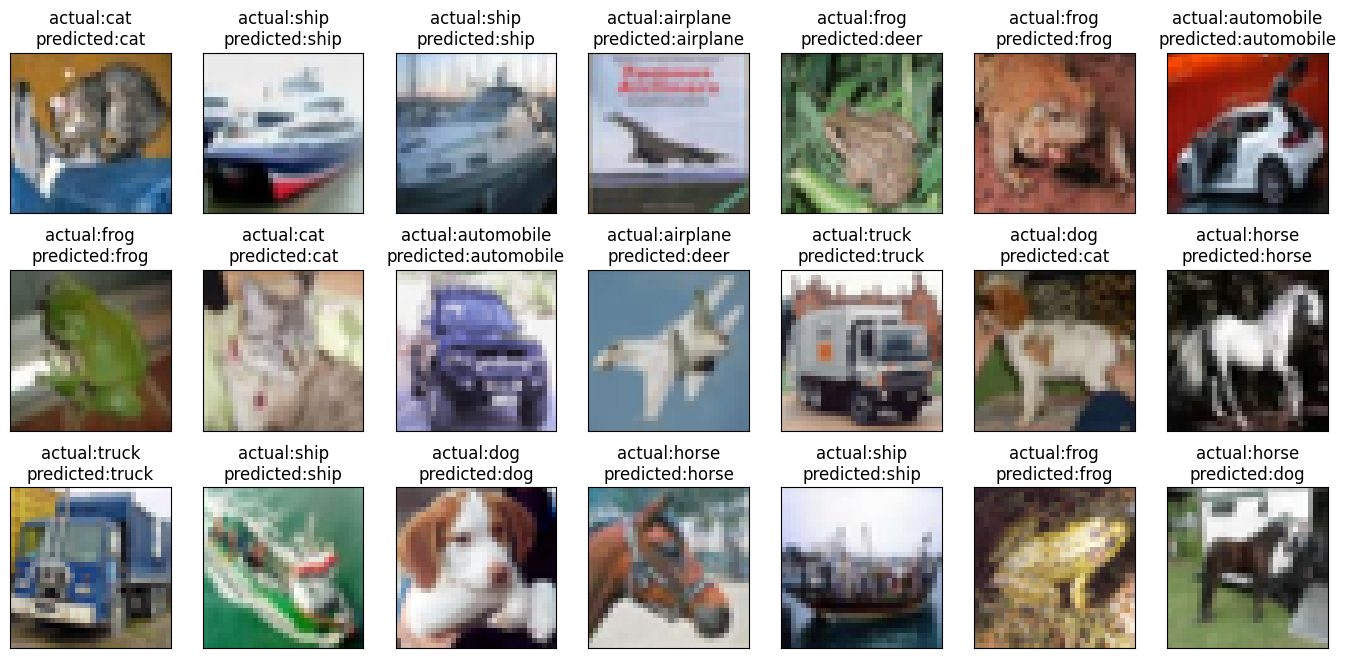

In [26]:


# Displaying test data with its actual and predicted label
print(X_test.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3])

# Plot actual vs. predicted labels
fig, axes = plt.subplots(ncols=7, nrows=3, sharex=False, sharey=True, figsize=(17, 8))
for i in range(3):
    for j in range(7):
        idx = i * 7 + j  # Calculate the correct index
        actual_label = labels[int(y_test_single_label[idx])]
        predicted_label = labels[int(predictions[idx])]
        axes[i,j].set_title('actual:' + actual_label + '\n' + 'predicted:' + predicted_label)
        axes[i,j].imshow(X_test[idx], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)